In [54]:
!pip install joblib
!pip install pandas==0.20.2

    100% |################################| 184kB 2.9MB/s 


In [1]:
import google.cloud.storage as gcs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import joblib
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
modelnames = ['LSTM', 'Random Forest']

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
sns.set_style('whitegrid')

## Dimensionality Reduction

In [3]:
client = gcs.Client('user-lifecycle')
bucket = gcs.Bucket(client, 'helder')

In [4]:
dsnames = ['56_30d']
models = {'lstm_4f': {'name':'LSTM'}, 'lstm_16f': {'name':'LSTM'}, 'lstm_28f': {'name':'LSTM'}, 
          'lstm_40f': {'name':'LSTM'}, 'lstm_52f': {'name':'LSTM'},
          'rf_4f': {'name':'Random Forest'}, 'rf_16f': {'name':'Random Forest'}, 'rf_28f': {'name':'Random Forest'}, 
          'rf_40f': {'name':'Random Forest'}, 'rf_52f': {'name':'Random Forest'}}
expname = 'dim_reduction'

for model, metrics in models.items():
    metrics['prec_recs'] = []
    metrics['pr_aucs'] = []
    metrics['f1s'] = []
    metrics['confusions'] = []
    metrics['roc_aucs'] =  []
    metrics['fpr_tprs'] = []
    metrics['cvs'] = []
    metrics['th_metrics'] = []  
  
    for dsname in dsnames:
        blob = gcs.Blob(name='churnr/{}/{}/{}/y_test_true_pred.gz'.format(expname, dsname, model), bucket=bucket)
        predpath = '/tmp/{}_{}_{}_y_test_true_pred.gz'.format(expname, dsname, model)
        cvpath = '/tmp/{}_{}_{}_cv_results.csv'.format(expname, dsname, model)
        with open(predpath, 'wb') as f:
            blob.download_to_file(f)
        blob = gcs.Blob(name='churnr/{}/{}/{}/cv_results.csv'.format(expname, dsname, model), bucket=bucket)
        with open(cvpath, 'wb') as f:
            blob.download_to_file(f)

        y_trpred = joblib.load(predpath)
        y_true = y_trpred[:,0]
        y_pred = y_trpred[:,1]
        y_true_ret = 1.0 - y_true 
        y_pred_ret = 1.0 - y_pred

        # calculate PR AUC
        prec, rec, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)
        pr_auc_ret = average_precision_score(y_true_ret, y_pred_ret)

        # calculate some metrics by thresholding to 0.5, maybe it would be smarter to use on of the thresholds
        #   returned by precision_recall_curve()
        y_pred_th = np.array([0.0 if i <= 0.5 else 1.0 for i in y_pred])
        f1 = f1_score(y_true, y_pred_th)  
        prec_th, rec_th, fbeta_th, supp_th = precision_recall_fscore_support(y_true, y_pred_th)

        # calculate the confusion matrix
        cfm = confusion_matrix(y_true, y_pred_th)

        # calculate ROC curve and ROC AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # load CV results
        cv = pd.read_csv(cvpath)

        metrics['pr_aucs'].append(pr_auc)
        metrics['prec_recs'].append((prec, rec))  
        metrics['f1s'].append(f1)
        metrics['confusions'].append(cfm)
        metrics['roc_aucs'].append(roc_auc)
        metrics['fpr_tprs'].append((fpr, tpr))
        metrics['cvs'].append(cv)
        metrics['th_metrics'].append((prec_th, rec_th, fbeta_th, (pr_auc_ret, pr_auc)))

### Precision-Recall Curves

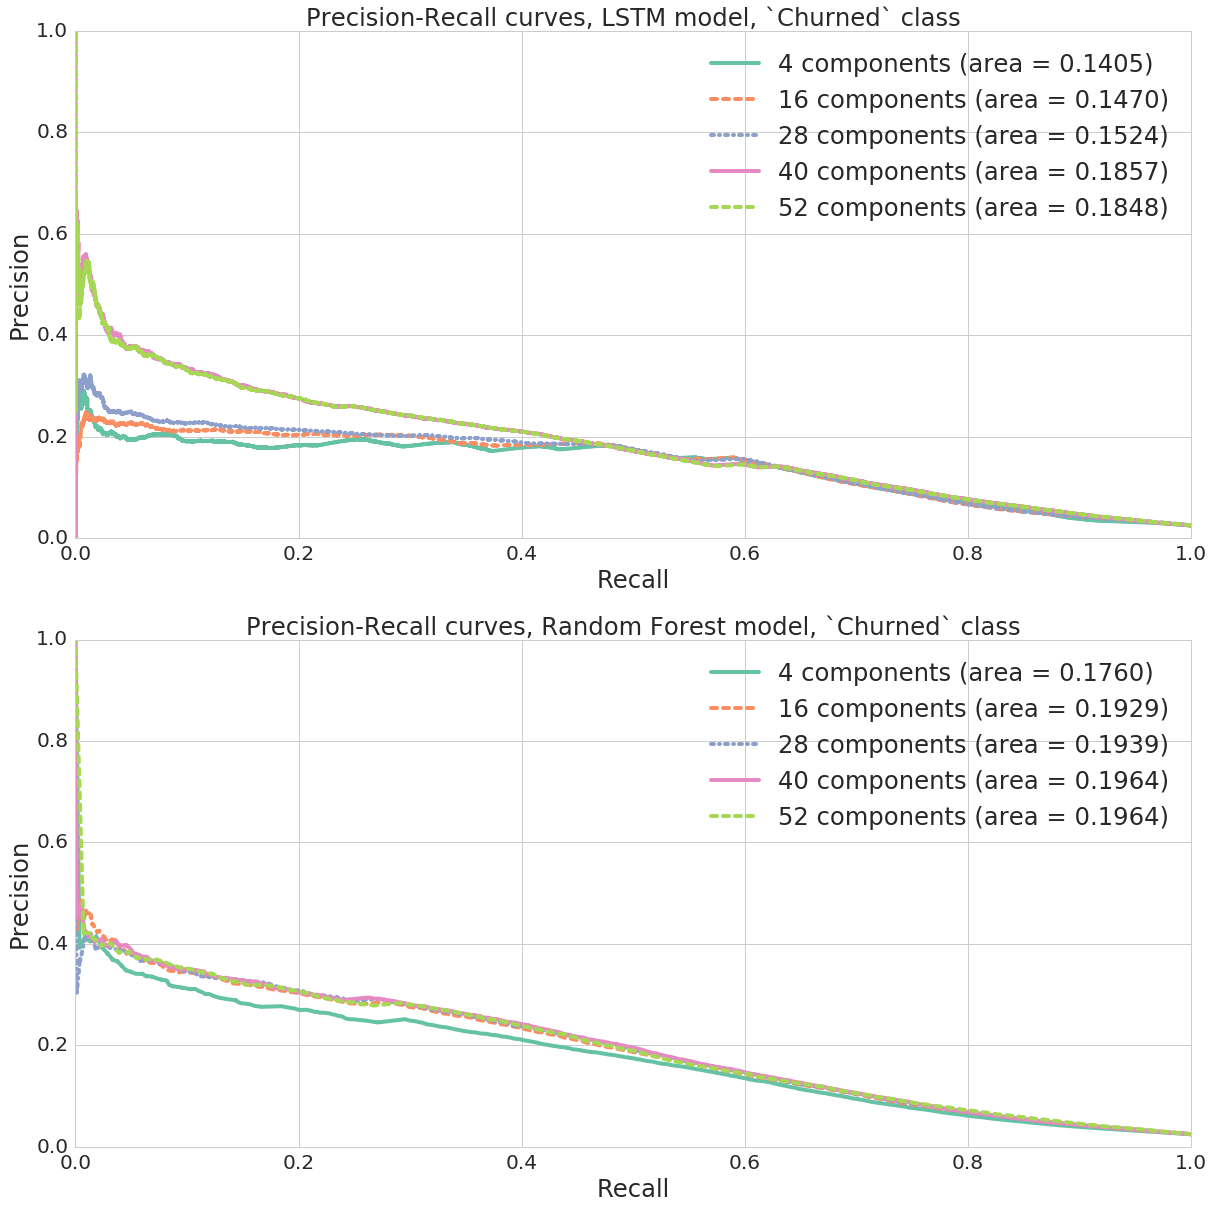

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(20,20))

linestyles = ['-', '--', '-.']*3
for ax, model in zip(axs, ['lstm', 'rf']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Recall', fontsize='xx-large')
    ax.set_ylabel('Precision', fontsize='xx-large')
    ax.set_title('Precision-Recall curves, {} model, `Churned` class'.format(models[model+'_4f']['name']), fontsize='xx-large')

    for ft, ls in zip(['4f', '16f', '28f', '40f', '52f'], linestyles):    
      metrics = models[model+'_'+ft]
      for prec_rec, pr_auc, dsname, f1 in zip(metrics['prec_recs'], metrics['pr_aucs'], dsnames, metrics['f1s']):
          prec = prec_rec[0]
          rec = prec_rec[1]
          ax.plot(rec, prec, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(ft[:-1]+' components', pr_auc))

    ax.tick_params(labelsize='x-large')
    ax.legend(fontsize='xx-large', loc='best')
    
#plt.savefig('prc_dim_reduction.pdf', bbox_inches='tight')
#!gsutil cp 'prc_dim_reduction.pdf' 'gs://helder/churnr/plots/prc_dim_reduction.pdf'

### ROC Curves

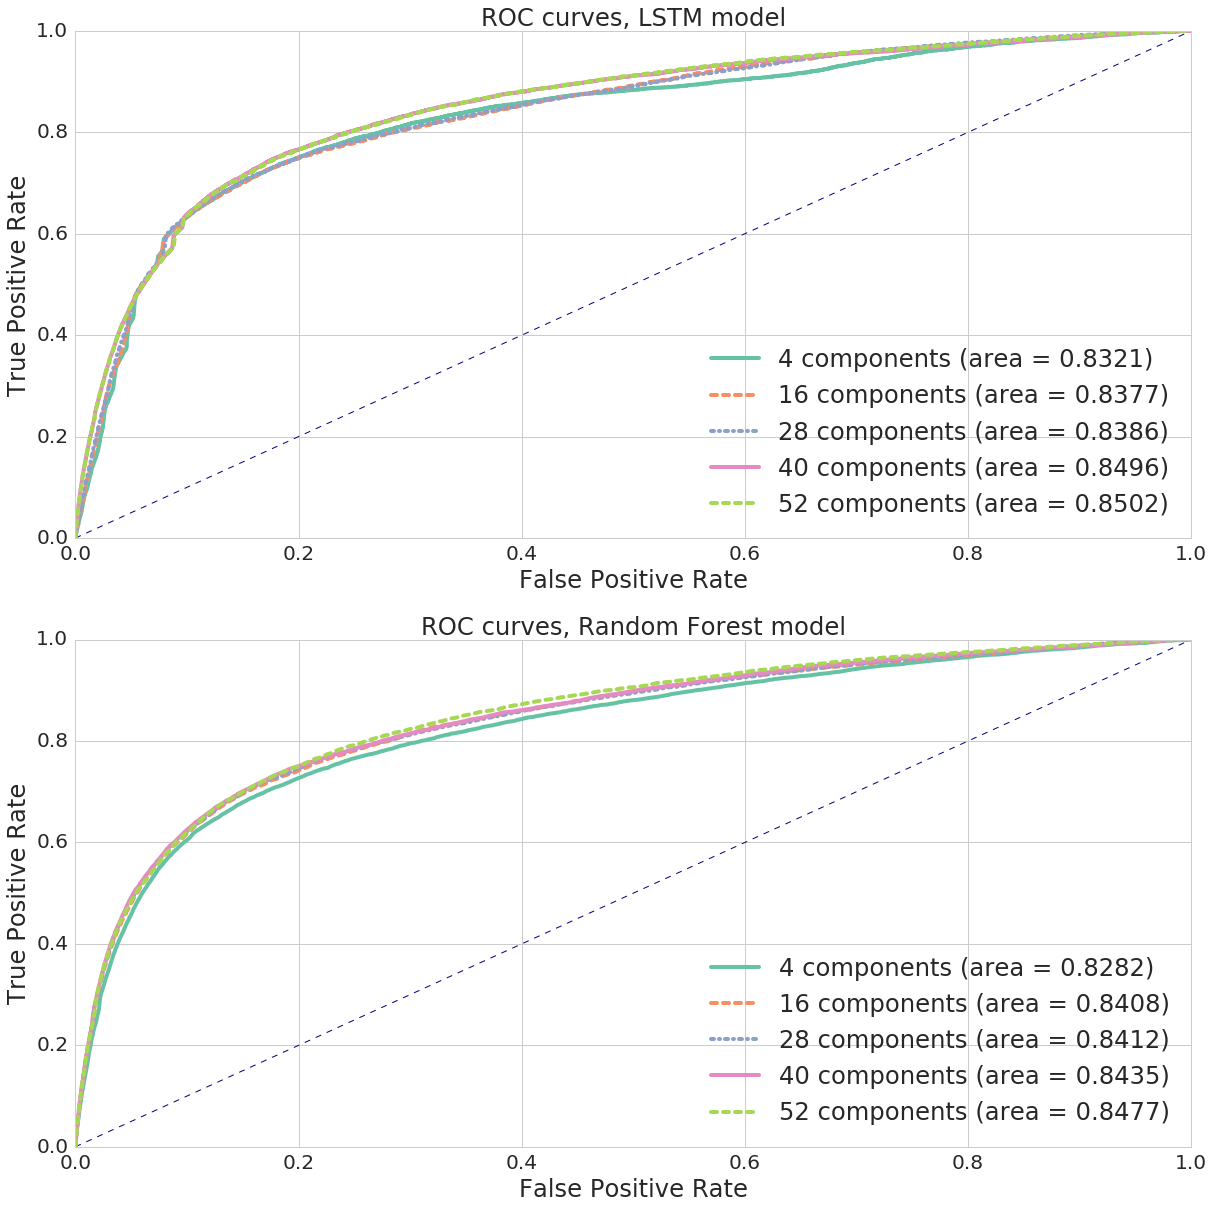

In [11]:
fig, axs = plt.subplots(nrows=2, figsize=(20,20))

linestyles = ['-', '--', '-.']*3
for ax, model in zip(axs, ['lstm', 'rf']):
  ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.set_xlabel('False Positive Rate', fontsize='xx-large')
  ax.set_ylabel('True Positive Rate', fontsize='xx-large')
  ax.set_title('ROC curves, {} model'.format(models[model+'_4f']['name']), fontsize='xx-large')

  for ft, ls in zip(['4f', '16f', '28f', '40f', '52f'], linestyles):    
    metrics = models[model+'_'+ft]
    for fpr_tpr, roc_auc, in zip(metrics['fpr_tprs'], metrics['roc_aucs']):
      fpr = fpr_tpr[0]
      tpr = fpr_tpr[1]
      ax.plot(fpr, tpr, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(ft[:-1]+' components', roc_auc))

  ax.tick_params(labelsize='x-large')
  ax.legend(fontsize='xx-large', loc='best')

#plt.savefig('roc_dim_reduction.pdf', bbox_inches='tight')
#!gsutil cp 'roc_dim_reduction.pdf' 'gs://helder/churnr/plots/roc_dim_reduction.pdf'

### Overall scores

In [12]:
dfs_models = []
fts = ['4f', '16f', '28f', '40f', '52f']
for model in ['lstm','rf']:
  dfs = []
  
  for cb in fts:
    metric = models[model+'_'+cb]['th_metrics'][0]
    vals = {'Precision': metric[0], 'Recall': metric[1], 'F1-Score': metric[2], 'PR AUC': metric[3]}
    df = pd.DataFrame(vals, index=pd.Index(['Retained','Churned'], name='Label'))
    dfs.append(df)
  dfs = pd.concat(dfs, keys=[n[:-1] for n in fts], names=['# Features'])
  dfs_models.append(dfs)
dfs_models = pd.concat(dfs_models, keys=['LSTM', 'Random Forest'], names=['Models'])
#print(dfs_models.to_latex(multirow=True))
dfs_models

F1-Score    PR AUC  Precision    Recall
Models        # Features Label                                            
LSTM          4          Retained  0.922415  0.993324   0.990890  0.862792
                         Churned   0.193373  0.140500   0.112527  0.686835
              16         Retained  0.927496  0.993826   0.990609  0.871943
                         Churned   0.200218  0.146970   0.117582  0.673661
              28         Retained  0.924869  0.993922   0.990807  0.867160
                         Churned   0.197016  0.152360   0.115129  0.682346
              40         Retained  0.902679  0.994233   0.992157  0.828005
                         Churned   0.173838  0.185674   0.098459  0.741583
              52         Retained  0.898539  0.994353   0.992256  0.820997
                         Churned   0.169514  0.184844   0.095604  0.747048
Random Forest 4          Retained  0.886591  0.993103   0.991396  0.801825
                         Churned   0.151906  0.175956   0.084837  0.725285
              16         Retained  0.903003  0.993781   0.991422  0.829063
                         Churned   0.169349  0.192872   0.096017  0.716795
              28         Retained  0.906450  0.993801   0.991455  0.834870
                         Churned   0.173868  0.193854   0.098949  0.715917
              40         Retained  0.906357  0.993904   0.991499  0.834682
                         Churned   0.174057  0.196415   0.099042  0.717478
              52         Retained  0.895238  0.994219   0.991906  0.815740
                         Churned   0.163607  0.196442   0.092014  0.737191

### F1-scores for different number of principal components

(0.0, 0.4)

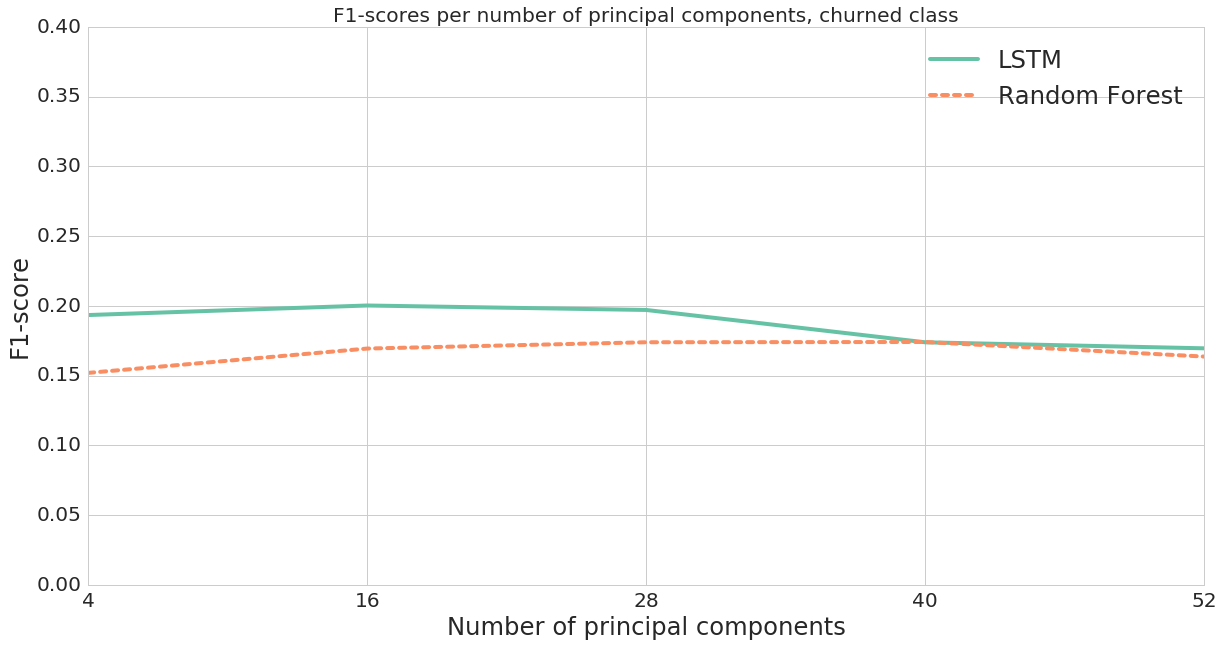

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_title('F1-scores per number of principal components, churned class')
ax.set_xlabel('Number of principal components', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--']
for modeltype, ls in zip(['LSTM','Random Forest'], linestyles):
  vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(list(range(len(vals))), vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0, 4.0])
ax.set_xticklabels(['4', '16', '28', '40', '52'])

ax.set_ylim(0.0,0.4)

#plt.savefig('line_dim_reduction.pdf', bbox_inches='tight')
#!gsutil cp 'line_dim_reduction.pdf' 'gs://helder/churnr/plots/line_dim_reduction.pdf'

(0.6, 1.0)

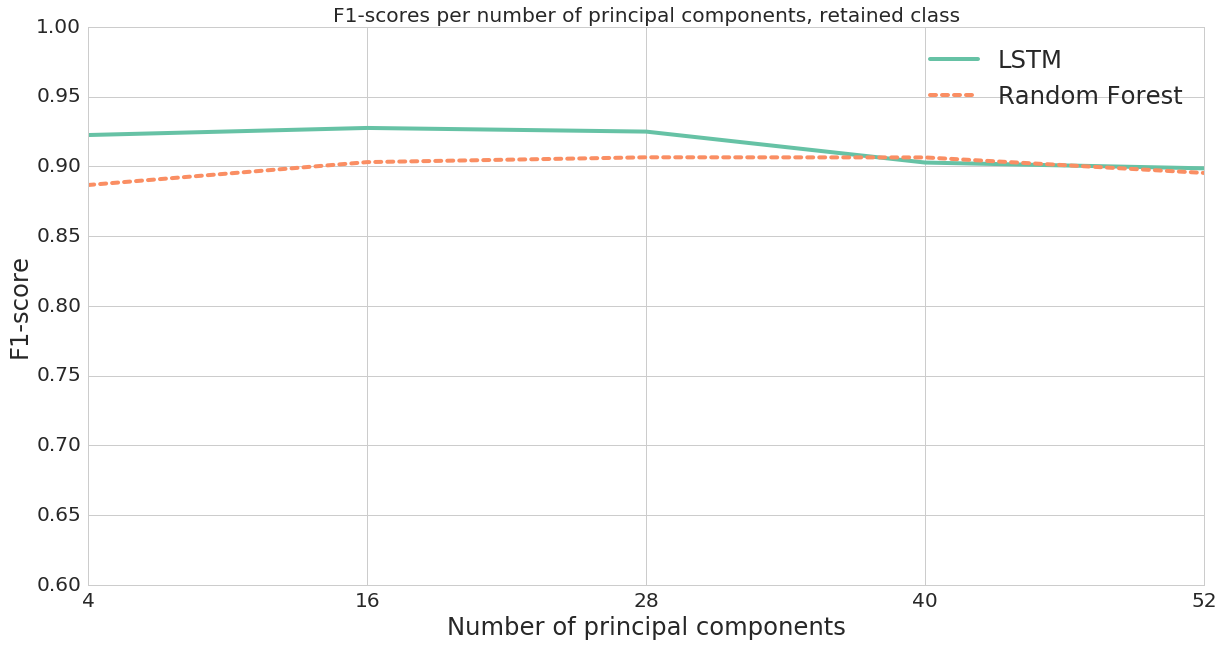

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_title('F1-scores per number of principal components, retained class')
ax.set_xlabel('Number of principal components', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyle = ['-', '--']
for modeltype, ls in zip(['LSTM','Random Forest'], linestyles):
  vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(list(range(len(vals))), vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0, 4.0])
ax.set_xticklabels(['4', '16', '28', '40', '52'])

ax.set_ylim(0.6,1.0)

#plt.savefig('line_dim_reduction_retained.pdf', bbox_inches='tight')
#!gsutil cp 'line_dim_reduction_retained.pdf' 'gs://helder/churnr/plots/line_dim_reduction_retained.pdf'